In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_dir = '/home/hammad/my_project_dir/flowers'
class_names = [name for name in os.listdir(data_dir)]
print(class_names)

['flowers', 'tulip', 'rose', 'sunflower', 'daisy', 'dandelion']


In [5]:
image_height = 150
image_width = 150

batch_size = 32

# Create function to convert file path into image, label pair

In [6]:
def get_label(path):
    parts = tf.strings.split(path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [7]:
def decode_image(image):
    image = tf.io.decode_jpeg(image, channels=3)
    return tf.image.resize(image, [image_height, image_width])

In [8]:
def process_path(path):
    label = get_label(path)
    image = tf.io.read_file(path)
    image = decode_image(image)
    return image, label

# Create dataset using tf.data

In [10]:
autotune = tf.data.experimental.AUTOTUNE

dataset = tf.data.Dataset.list_files(f'{data_dir}/*/*.jpg', shuffle=True)
dataset = dataset.map(process_path, num_parallel_calls=autotune)

train_size = int(len(dataset) * 0.9)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

val_size = int(len(train_dataset) * 0.2)
val_dataset = train_dataset.take(val_size)
train_dataset = train_dataset.skip(val_size)

In [11]:
def configure_dataset(ds):
    ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(autotune)
    return ds

In [12]:
train_dataset = configure_dataset(train_dataset)
val_dataset = configure_dataset(val_dataset)
test_dataset = configure_dataset(test_dataset)

# Create model

In [13]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(image_width, image_height, 3)),
#     keras.layers.experimental.preprocessing.RandomFlip(),
#     keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     keras.layers.experimental.preprocessing.RandomZoom((0.2, 0.3)),
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0

# Configure model

In [14]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# Training model

In [15]:
hist = model.fit(train_dataset,
                 epochs=20,
                 validation_data=val_dataset)

Epoch 1/20
98/98 [==============================] - 86s 851ms/step - loss: 1.6473 - accuracy: 0.2446 - val_loss: 1.3046 - val_accuracy: 0.4280
Epoch 2/20
98/98 [==============================] - 82s 836ms/step - loss: 1.3723 - accuracy: 0.3895 - val_loss: 1.2194 - val_accuracy: 0.4987
Epoch 3/20
98/98 [==============================] - 84s 860ms/step - loss: 1.2199 - accuracy: 0.4723 - val_loss: 1.0500 - val_accuracy: 0.5964
Epoch 4/20
98/98 [==============================] - 84s 856ms/step - loss: 1.0521 - accuracy: 0.5846 - val_loss: 0.9284 - val_accuracy: 0.6491
Epoch 5/20
98/98 [==============================] - 85s 863ms/step - loss: 0.9792 - accuracy: 0.6213 - val_loss: 0.7764 - val_accuracy: 0.7108
Epoch 6/20
98/98 [==============================] - 84s 854ms/step - loss: 0.8140 - accuracy: 0.6972 - val_loss: 0.7388 - val_accuracy: 0.7224
Epoch 7/20
98/98 [==============================] - 84s 857ms/step - loss: 0.7190 - accuracy: 0.7351 - val_loss: 0.7216 - val_accuracy: 0.7429

# Visualize training and validation

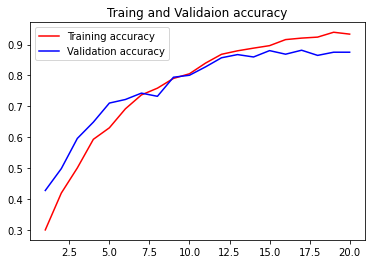

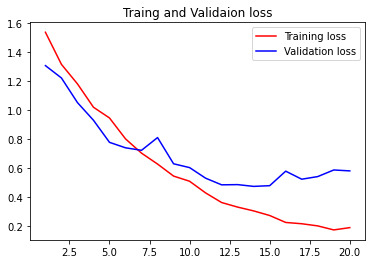

In [16]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Traing and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Traing and Validaion loss')
plt.legend()

plt.show()


# Make predictions

In [17]:
import matplotlib.pyplot as plt

predictions = model.predict(test_dataset)

index = 20

for img, label in test_dataset.take(1):
    print('True label:', class_names[label[index]])
    img = keras.preprocessing.image.array_to_img(img[index])
    

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions[index])], 100 * np.max(predictions[index]))
)

True label: daisy
This image most likely belongs to daisy with a 99.12 percent confidence.


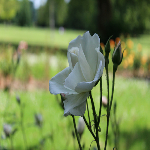

In [15]:
img